In [1]:
import pandas as pd
import numpy as np
import os
import re
import csv
from scipy.spatial.distance import euclidean
from unidecode import unidecode
from tslearn.metrics import dtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

/usr/local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 🧹 Cleaning

begin with `ids.csv`, `/pitch`, `/words` populated from the spreadsheet.

1. make sure filenames in `/pitch` and `/words` are valid ids
2. make sure all csvs are formatted with the correct columns
3. in `/words`, give all words unique labels for repeats
4. in `/pitch`, transpose notes to the standard key + filter out some frequencies
5. write cleaned data to `/pitch-cleaned` and `/words-cleaned`

In [ ]:
def clean():
    folders = ['pitch', 'words']
#     easy_filename_fixes(folders)

    missing_ids = check_ids()
    
    print('Checking for all ids in /pitch and /words')
    if len(missing_ids) > 0:
        print(f"{len(missing_ids)} missing files.")
        print(missing_ids)
#         return
    else:
        print('All good ✅')
    
#     add_columns_to_pitch()
#     add_columns_to_words()
#     sweep_ending_commas()
    invalid_csvs = check_csvs(folders)
    
    print('Checking valid csv format')
    if (len(invalid_csvs) > 0):
        print(f"{len(invalid_csvs)} invalid csvs.")
        print(invalid_csvs)
        return
    else:
        print('All good ✅')
    
#     print('Cleaning /words - unique word ids')
#     clean_words()
#     print('Done ✅')
    
    print('Cleaning /pitch - transposing and filtering')
    clean_pitch()
    print('Done ✅')

clean()

Checking for all ids in /pitch and /words
7 missing files.
['pia-toscano_memorial-day-concert_2022(pitch)', 'carrie-underwood_mlb-allstar-game_2006(pitch)', 'amber-riley_mlb-allstar-game_2010(pitch)', 'jordin-sparks_mlb-allstar-game_2011(pitch)', 'donna-summer_mlb-allstar-game_1999(pitch)', 'brian-mcknight_mlb-allstar-game_2005(pitch)', 'matthew-morrison_world-series_2012(pitch)']
Checking valid csv format
All good ✅
Cleaning /pitch - transposing and filtering
1: patrick-stump_world-series_2016_pitch.csv
2: gretchen-wilson_nba-allstar-game_2010_pitch.csv
3: kelly-clarkson_indy-500_2019_pitch.csv
4: carly-pearce_world-series_2021_pitch.csv
5: trisha-yearwood_world-series_2014_pitch.csv
6: kelly-clarkson_world-series_2010_pitch.csv
7: jordan-smith_nfl-regular-season_2023_pitch.csv
8: luke-bryan_super-bowl_2017_pitch.csv
9: fergie_nba-allstar-game_2018_pitch.csv
10: alicia-keys_super-bowl_2013_pitch.csv
11: hunter-hayes_world-series_2016_pitch.csv
12: taylor-swift_world-series_2008_pitch.

In [2]:
def easy_filename_fixes(folders):
    pattern = re.compile(r'^[\w-]+_[\w-]+_\d{4}_(pitch|words)\.csv$')

    for folder in folders:
        for filename in os.listdir(folder):
            if pattern.match(filename) or filename == '.DS_Store':
                # Filename is correct, no action needed
                continue
                
            parts = filename.split('_')
            
            if len(parts) == 3 and '-' in parts[2]:
                correct_filename = f"{parts[0]}_{parts[1]}_{parts[2].split('-')[0]}_{parts[2].split('-')[1].lower()}"
                os.rename(os.path.join(folder, filename), os.path.join(folder, correct_filename))
                print(f"Renamed '{filename}' to '{correct_filename}'")
            elif len(parts) == 4 and any(char.isupper() for char in parts[3]):
                correct_filename = f"{parts[0]}_{parts[1]}_{parts[2]}_{parts[3].lower()}"
                os.rename(os.path.join(folder, filename), os.path.join(folder, correct_filename))
                print(f"Renamed '{filename}' to '{correct_filename}'")

def check_ids():
    missing_ids = []
    with open('ids.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_value = row['id']
            words_file = f'words/{id_value}_words.csv'
            pitch_file = f'pitch/{id_value}_pitch.csv'

            if not os.path.isfile(words_file):
                missing_ids.append(id_value + '(words)')
            if not os.path.isfile(pitch_file):
                missing_ids.append(id_value + '(pitch)')

    return missing_ids

In [23]:
def check_csvs(folders):
    invalid_csvs = []
    for folder in folders:
        expected_columns = ["timestamp", "frequency"] if folder == 'pitch' else ["timestamp", "frequency", "duration", "word"]

        for filename in os.listdir(folder):
            if not filename.endswith('csv'): continue
            
            valid = check_csv_columns(os.path.join(folder, filename), expected_columns)
            if not valid:
                invalid_csvs.append(os.path.join(folder, filename))

    return invalid_csvs
            
def check_csv_columns(file_path, expected_columns):
    # Read the first line of the CSV
    df = pd.read_csv(file_path, nrows=1)

    # Get the actual column names from the DataFrame
    actual_columns = df.columns.tolist()

    # Check if the actual columns match the expected columns
    if actual_columns != expected_columns:
        return False
    return True
        
def sweep_ending_commas():
    folder = 'words'
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder, filename)

            with open(file_path, 'r') as file:
                lines = file.readlines()

            modified_lines = []
            for line in lines:
                # Strip newline character temporarily for processing
                line = line.rstrip('\n')
                
                # Iteratively remove trailing commas and spaces
                while line and line[-1] in {' ', ','}:
                    line = line[:-1]

                # Re-add the newline character
                modified_lines.append(line + '\n')

            with open(file_path, 'w') as file:
                file.writelines(modified_lines)
                    
def add_columns_to_pitch():
    folder = 'pitch'
    header = "timestamp,frequency\n"

    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder, filename)

            with open(file_path, 'r') as file:
                first_line = file.readline()
                rest_of_file = file.read()

            # Check if the first line is already the header
            if first_line.strip() != header.strip():
                # Prepend the header to the content
                new_content = header + first_line + rest_of_file

                # Write the new content back to the file
                with open(file_path, 'w') as file:
                    file.write(new_content)

def add_columns_to_words():
    folder = 'words'
    header = "timestamp,frequency,duration,word\n"

    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder, filename)

            with open(file_path, 'r') as file:
                lines = file.readlines()

            # Check if the first line starts with a number
            if lines and lines[0].split(',')[0].replace('.', '', 1).isdigit():
                # Prepend the header
                lines.insert(0, header)

                # Write the modified lines back to the file
                with open(file_path, 'w') as file:
                    file.writelines(lines)

In [14]:
def clean_words():
    output_folder = 'words-cleaned'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ids = pd.read_csv('ids.csv')
    for id in ids['id']:
        filename = f'words/{id}_words.csv'
        if os.path.exists(filename):
            words = pd.read_csv(filename)            
            words_cleaned = unique_word_labels(words)
            words_cleaned.to_csv(f'{output_folder}/{id}.csv', index=False)
        
def unique_word_labels(data):
    word_count = {}
    last_word = None
    unique_data = []

    for index, row in data.iterrows():
        word = row['word']
        
        # Check if this is a repeated word
        if word == last_word:
            # Use the same label as the previous occurrence if it's in a clump
            unique_word = unique_data[-1]['word']
        else:
            # If it's a new occurrence or a different word
            count = word_count.get(word, 0) + 1
            word_count[word] = count

            if count == 1:
                unique_word = word  # First occurrence remains the same
            else:
                unique_word = f"{word}-{count}"  # Label subsequent occurrences uniquely

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        last_word = word  # Update the last seen word
    return pd.DataFrame(unique_data)

In [42]:
standard_key = 'C'

def clean_pitch():
    output_folder = 'pitch-cleaned'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    current_file_number = 0
    for filename in os.listdir('pitch'):
        if not filename.endswith('csv'): continue
            
        current_file_number += 1
        print(f"{current_file_number}: {filename}")
        
            
        id_value = filename.replace('_pitch.csv', '')
        id_df = pd.read_csv('ids.csv')
        row = id_df[id_df['id'] == id_value]
        steps_from_C = row['steps_from_C'].iloc[0]
        
        pitch = pd.DataFrame(pd.read_csv('pitch/' + filename))
        filtered_pitch = filter_frequencies(pitch)
        
        if steps_from_C == 0:
            pitch_cleaned = filtered_pitch
        else:
            pitch_cleaned = normalize_pitch(filtered_pitch, steps_from_C)
        
        pitch_cleaned.to_csv(output_folder + '/' + filename, index=False)

def transpose(original_hz, steps_from_C):
    new_frequency = original_hz * (2 ** (steps_from_C / 12))
    return new_frequency

def normalize_pitch(pitch_data, steps_from_C):
    normalized = []
    for index, row in pitch_data.iterrows():
        new_row = {col: row[col] for col in pitch_data.columns}
        new_row['frequency'] = transpose(row['frequency'], steps_from_C)
        normalized.append(new_row)
    return pd.DataFrame(normalized)

def filter_frequencies(data):
    data['frequency'] = pd.to_numeric(data['frequency'], errors='coerce')
    return data[data['frequency'] >= 100]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


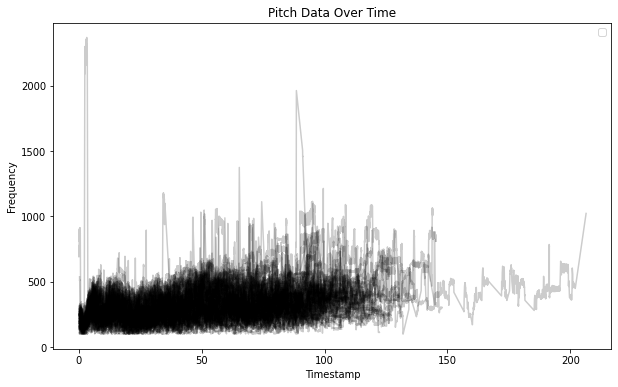

In [9]:
def plot_pitches():
    plt.figure(figsize=(10, 6))

    for filename in os.listdir('pitch-cleaned'):
        if filename.endswith('.csv'):
            file_path = os.path.join('pitch-cleaned', filename)

            # Read the CSV file
            data = pd.read_csv(file_path)

            # Plot the data
            plt.plot(data['timestamp'], data['frequency'], color='black', alpha=0.2)

    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.title('Pitch Data Over Time')
    plt.legend()
    plt.show()

plot_pitches()

# 🎤 DIVA 

## D = Density

Total notes in the performance compared to the standard performance.

In [8]:
def density(id):
    standard = performances['michelle']
    standard_length = len(standard['words_data'])
    length = len(performances[id]['words_data'])
    return ((length - standard_length) / standard_length)*100

In [35]:
# The top n by density
n = 3
density_dict = {performer: density(performer) for performer, data in performances.items()}
sorted_density = sorted(density_dict.items(), key=lambda x: x[1], reverse=True)[:n]
for performer, density_value in sorted_density:
    print(f"{performer}: {density_value}")

jazmine: 97.84172661870504
demi: 58.992805755395686
carrie: 41.007194244604314


## I = Interpretation

Comparing the pitch curve to the standard curve using DTW.

In [29]:
standard_performance = np.array(performances['michelle']['pitch_data']['frequency'].tolist())
dtw_differences = {}

for name, performance in performances.items():
    print(name)
    if name != 'michelle':
        current_performance = np.array(performance['pitch_data']['frequency'].tolist())
        distance = dtw(standard_performance, current_performance)
        dtw_differences[name] = distance
print('done')

michelle
jazmine
demi
carrie
harry
done


In [36]:
# Print top n DTW distances in descending order
n = 3
top_5 = sorted(dtw_differences.items(), key=lambda x: x[1], reverse=True)[:n]
for name, distance in top_5:
    print(f"{name}: {distance}")

jazmine: 5321.627768189828
demi: 5001.383439416785
carrie: 2900.211028984833


## V = Vibrato

Measuring how much vibrato they use.

I think we might want to cut this one

[(89.776, 90.08), (89.776, 90.085333333), (89.776, 90.090666667), (89.776, 90.096), (89.776, 90.101333333), (89.776, 90.106666667), (89.776, 90.112), (89.776, 90.117333333), (89.776, 90.122666667), (89.776, 90.128), (89.776, 90.133333333), (89.776, 90.138666667), (89.776, 90.144), (89.776, 90.149333333), (89.776, 90.154666667), (89.776, 90.16), (89.776, 90.165333333), (89.776, 90.170666667), (89.776, 90.176), (89.776, 90.181333333), (89.776, 90.186666667), (89.776, 90.192), (89.776, 90.197333333), (89.776, 90.202666667)]
Vibrato score for michelle: 150


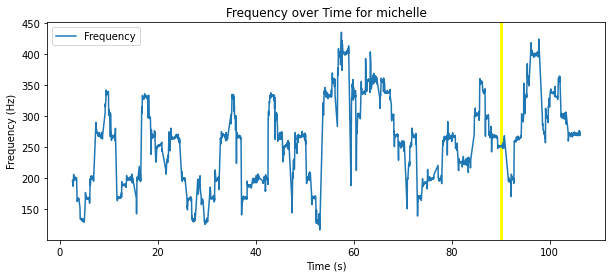

[(99.723900227, 100.025759637), (99.723900227, 100.031564626), (99.723900227, 100.037369615), (99.723900227, 100.043174603), (99.723900227, 100.048979592), (99.723900227, 100.05478458), (99.723900227, 100.060589569), (99.723900227, 100.066394558), (99.723900227, 100.072199546), (99.723900227, 100.078004535), (99.723900227, 100.083809524), (99.723900227, 100.089614512), (99.723900227, 100.095419501), (99.723900227, 100.10122449), (99.723900227, 100.107029478), (99.723900227, 100.112834467), (99.723900227, 100.118639456), (100.223129252, 100.524988662)]
Vibrato score for jazmine: 235


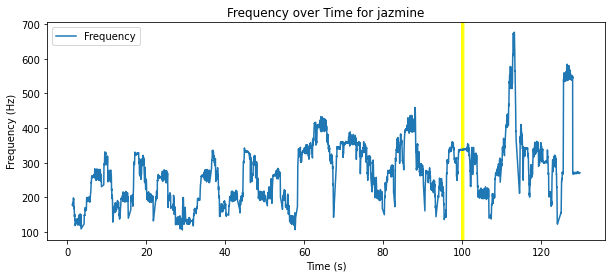

[]
Vibrato score for demi: 0


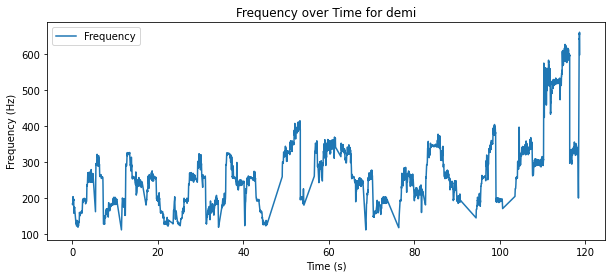

[(48.477460317, 48.779319728), (48.477460317, 48.785124717), (48.477460317, 48.790929705), (48.477460317, 48.796734694), (48.477460317, 48.802539683), (48.477460317, 48.808344671), (48.477460317, 48.81414966), (48.477460317, 48.819954649), (48.477460317, 48.825759637), (48.477460317, 48.831564626), (48.477460317, 48.837369615), (48.477460317, 48.843174603), (48.477460317, 48.848979592), (48.477460317, 48.85478458), (48.477460317, 48.860589569), (48.477460317, 48.866394558), (48.477460317, 48.872199546), (48.477460317, 48.878004535), (48.477460317, 48.883809524), (48.477460317, 48.889614512), (48.477460317, 48.895419501), (48.477460317, 48.90122449), (48.477460317, 48.907029478), (48.477460317, 48.912834467), (48.477460317, 48.918639456), (48.477460317, 48.924444444), (48.477460317, 48.930249433), (48.477460317, 48.936054422), (48.477460317, 48.94185941), (48.477460317, 48.947664399), (48.477460317, 48.953469388), (48.477460317, 48.959274376), (48.477460317, 48.965079365), (48.477460317

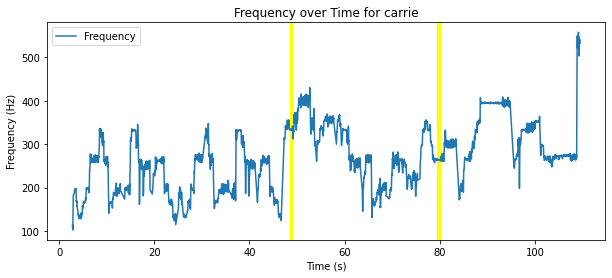

[(105.250249433, 105.552108844), (105.250249433, 105.557913832)]
Vibrato score for harry: 24


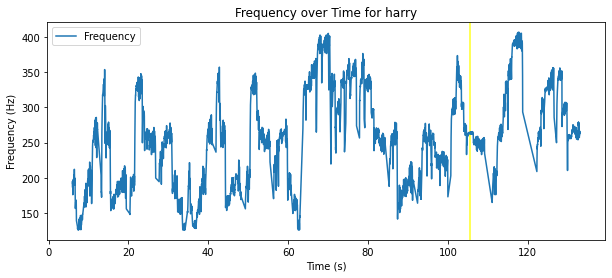

In [42]:
def detect_vibrato(pitch_data, min_duration=0.3, rate_threshold=5):
    """
    Detects vibrato in pitch data and returns the vibrato score and segments.

    :param pitch_data: DataFrame with 'timestamp' and 'frequency'.
    :param min_duration: Minimum duration (in seconds) to consider a note sustained.
    :param rate_threshold: Minimum rate of vibrato oscillations (in oscillations per second).
    :return: Vibrato score and list of vibrato segments (start and end times).
    """
    vibrato_score = 0
    vibrato_segments = []
    prev_freq = pitch_data['frequency'].iloc[0]
    start_time = pitch_data['timestamp'].iloc[0]

    for index, row in pitch_data.iterrows():
        freq_threshold = 0.07 * row['frequency']
        
        if abs(row['frequency'] - prev_freq) <= freq_threshold:
            duration = row['timestamp'] - start_time
            if duration >= min_duration:
                # Potential vibrato segment found
                segment = pitch_data[(pitch_data['timestamp'] >= start_time) & (pitch_data['timestamp'] <= row['timestamp'])]
                # Analyze for oscillation rate and depth
                oscillations = count_oscillations(segment, rate_threshold)
                vibrato_score += oscillations
                if oscillations > 0:
                    vibrato_segments.append((start_time, row['timestamp']))
        else:
            prev_freq = row['frequency']
            start_time = row['timestamp']

    return vibrato_score, vibrato_segments

def count_oscillations(segment, rate_threshold):
    frequencies = segment['frequency'].values
    timestamps = segment['timestamp'].values

    # Find peaks and troughs
    peaks = np.zeros(len(frequencies), dtype=bool)
    troughs = np.zeros(len(frequencies), dtype=bool)

    for i in range(1, len(frequencies) - 1):
        peaks[i] = frequencies[i] > frequencies[i - 1] and frequencies[i] > frequencies[i + 1]
        troughs[i] = frequencies[i] < frequencies[i - 1] and frequencies[i] < frequencies[i + 1]

    # Count cycles
    oscillation_count = 0
    in_cycle = False

    for i in range(1, len(frequencies) - 1):
        if (peaks[i] or troughs[i]) and not in_cycle:
            in_cycle = True
        elif in_cycle and (peaks[i] or troughs[i]):
            oscillation_count += 1
            in_cycle = False

    # Check rate of oscillations against the threshold
    duration = timestamps[-1] - timestamps[0]
    if duration > 0:
        rate = oscillation_count / duration
        if rate >= rate_threshold:
            return oscillation_count
    return 0


for name, performance in performances.items():
    vibrato_score, vibrato_segments = detect_vibrato(performance['pitch_data'])
    print(vibrato_segments)
    print(f"Vibrato score for {name}: {vibrato_score}")

    # Plotting the frequency over time
    plt.figure(figsize=(10, 4))
    plt.plot(performance['pitch_data']['timestamp'], performance['pitch_data']['frequency'], label='Frequency')
    
    # Highlight vibrato segments
    for start, end in vibrato_segments:
        plt.axvspan(start, end, color='yellow', alpha=0.3)

    plt.title(f"Frequency over Time for {name}")
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

## A = Apex

What's their highest note?

In [45]:
highest_frequencies = {name: performance['pitch_data']['frequency'].max() for name, performance in performances.items()}
n = 3
sorted_performances = sorted(highest_frequencies.items(), key=lambda x: x[1], reverse=True)[:n]

for name, freq in sorted_performances:
    print(f"The highest frequency in {name}'s performance: {freq} Hz")


The highest frequency in jazmine's performance: 676.7403574128907 Hz
The highest frequency in demi's performance: 661.4207535633116 Hz
The highest frequency in carrie's performance: 558.1321103126033 Hz
